# Final Project Submission

Please fill out:

* Student name: Justin Grisanti
* Student pace: self-paced
* Scheduled project review date/time: 2/23/2022 @ TBD
* Instructor name: Claude Fried
* Blog post URL: TBD

# Section 1: Business Understanding


The purpose of this section is to define the business problem and understand the stakeholders for the work that I am performing. Mount Sinai is a hospital network in New York City. The Health System includes more than 6,600 primary and specialty care physicians and 13 ambulatory surgical centers.

For years, doctors at Mount Sinai review chest x-rays and try to determine whether there a patient has pneumonia. Pneumonia is an infection of the lung. The lungs fill with fluid and make breathing difficult. Pneumonia disproportionately affects the young, the elderly, and the immunocompromised. It preys on weakness and vulnerability. 

According to a 2010 study performed by the Henry Ford Health System, Pneumonia ranks second to congestive heart failure as the reason for readmission within 30 days of a previous hospitalization. Here are some important findings from the study:

* 72 percent of patients were misdiagnosed with pneumonia upon readmission to the same hospital.
* African-Americans were twice more likely than Caucasians to be misdiagnosed with pneumonia.
* Patients who smoke or have lung disease were likely to be misdiagnosed with pneumonia.
* 72 percent of the misdiagnoses occurred in the Emergency Department.
* Fewer than 33 percent of patients had any outpatient follow-up care prior to their readmission.

With these statistics in mind, Mount Sinai has contracted me to use deep learning to more accurately predict whether a patient has pneumonia, given a patient's chest x-ray.

The stakeholders of this project are patients, doctors, and radiologists.

The main purpose of this classification model is predictive, meaning that given a picture of a patients chest, the model should be able to predict whether that patient has pneumonia or not.

# Section 2: Data Understanding

The data downloaded has three different folders, train data, test data, and validation data. Across all of the folders, we have 5,856 chest x-rays for patients that have/don't have pneumonia. Let's import our packages and then begin analyzing our train dataset.

In [269]:
import pandas as pd
from numpy.random import seed
seed(123)
import numpy as np
import random
import shutil
import math
import statistics as stat
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import sklearn as sk
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold
from keras import models, layers, regularizers, metrics, backend
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint

Let's begin with analyzing our different chest x-ray images for our train, test and validation datasets. As we can see below, the lungs in our class 'normal' x-rays appear to be clearer than the lungs in our 'pneumonia' class, and it seems like it harder to see the heart as a result of this. However, because I am not a doctor, if I removed the labels and had to guess if a patient had pneumonia or not, I would probably do a fairly poor job. This is where deep learning comes in. We can use deep learning to analyze these images further to see if we are able to better predict whether a patient has pneumonia or not.

In [270]:
input_path = 'data/chest_xray/'

class_labels=['NORMAL','PNEUMONIA']
X=[]
Y=[]

train_path=input_path+'/train/'
validation_path=input_path+'/val/'
test_path=input_path+'/test/'

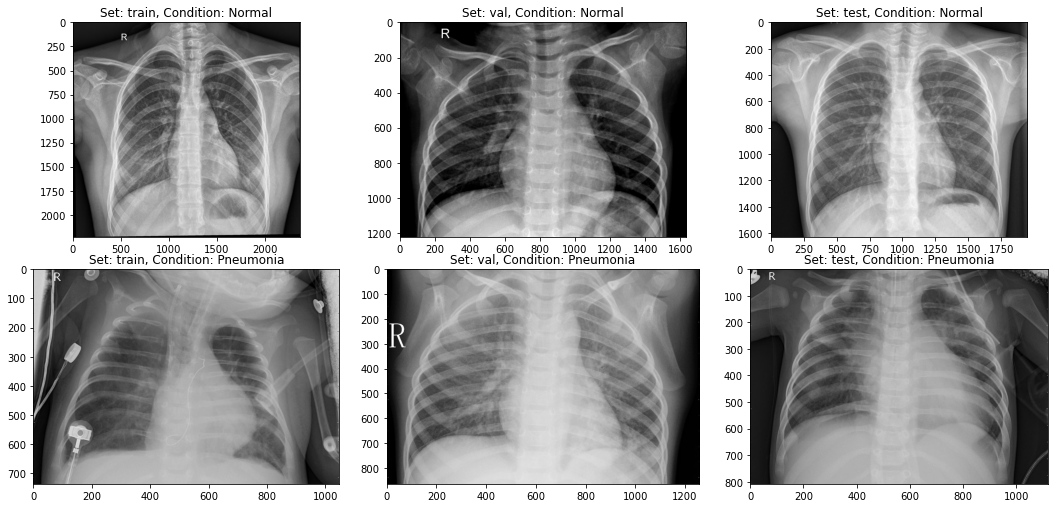

In [271]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [272]:
# Ran this cell to get the results below.

# total_image_count = []
# ill_image_count = []
# normal_image_count = []

#for _set in ['train','val', 'test']:
#    total_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
#    total_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
#    normal_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
#    ill_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
#    print(_set + '/NORMAL:', len(os.listdir(input_path + _set + '/NORMAL')))
#    print(_set + '/PNEUMONIA:',len(os.listdir(input_path + _set + '/PNEUMONIA')))

#print('\nValue Counts: \nNormal:',sum(normal_image_count)/sum(total_image_count), '\nPneumonia:',sum(ill_image_count)/sum(total_image_count))
#print('\nPopulation Breakdown: \nTrain:', (len(os.listdir(input_path + '/train/NORMAL'))+len(os.listdir(input_path + '/train/PNEUMONIA')))/5856,'\nTest:',(len(os.listdir(input_path + '/test/NORMAL'))+len(os.listdir(input_path + '/test/PNEUMONIA')))/5856,'\nVal:',(len(os.listdir(input_path + '/val/NORMAL'))+len(os.listdir(input_path + '/val/PNEUMONIA')))/5856)

#print('\nSum: ',sum(total_image_count))

train/NORMAL: 1342<br>
train/PNEUMONIA: 3873<br>
val/NORMAL: 9<br>
val/PNEUMONIA: 8<br>
test/NORMAL: 234<br>
test/PNEUMONIA: 390<br>
<br><br>
Value Counts: <br>
Normal: 0.27066256830601093 <br>
Pneumonia: 0.7293374316939891<br>
<br><br>
Population Breakdown: <br>
Train: 0.8905396174863388 <br>
Test: 0.10655737704918032 <br>
Val: 0.0029030054644808745<br>
<br><br>
Sum:  5856

Above, we can see our total population is broken down as 27% normal chest x-rays, and 73% pneumonia chest x-rays. If our model were to randomly guess, a 73% accuracy rate would be expected. We should expect a good model to have an accuracy rating that is better than 73%. Also, our train, test and val population is split by 89.1%, 10.7% and .2%, respectively. I am going to use K-Fold Cross Validation on the train dataset, so I will be combining the train and test data to then 

# Section 3: Data Preparation

The next steps are to prepare our data for modeling.

In [273]:
def move_img(input_source,input_dest,weight):
    files = os.listdir(input_source)
    num_files=int(len(os.listdir(input_source))*weight)
    for file_name in random.sample(files, num_files):
        shutil.move(os.path.join(input_source, file_name), input_dest)

In [274]:
#move_img(test_path+'/NORMAL',train_path+'/NORMAL',1)
#move_img(test_path+'/PNEUMONIA',train_path+'/PNEUMONIA',1)

In [275]:
#move_img(train_path+'/NORMAL',validation_path+'NORMAL',.02)
#move_img(train_path+'/PNEUMONIA',validation_path+'/PNEUMONIA',.02)

In [276]:
#move_img(train_path+'/NORMAL',test_path+'/NORMAL',.2)
#move_img(train_path+'/PNEUMONIA',test_path+'/PNEUMONIA',.2)

In [277]:
total_image_count = []
ill_image_count = []
normal_image_count = []

for _set in ['train','val', 'test']:
    total_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
    total_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
    normal_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
    ill_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
    print(_set + '/NORMAL:', len(os.listdir(input_path + _set + '/NORMAL')))
    print(_set + '/PNEUMONIA:',len(os.listdir(input_path + _set + '/PNEUMONIA')))

print('\nValue Counts: \nNormal:',sum(normal_image_count)/sum(total_image_count), '\nPneumonia:',sum(ill_image_count)/sum(total_image_count))
print('\nPopulation Breakdown: \nTrain:', (len(os.listdir(input_path + '/train/NORMAL'))+len(os.listdir(input_path + '/train/PNEUMONIA')))/5856,'\nTest:',(len(os.listdir(input_path + '/test/NORMAL'))+len(os.listdir(input_path + '/test/PNEUMONIA')))/5856,'\nVal:',(len(os.listdir(input_path + '/val/NORMAL'))+len(os.listdir(input_path + '/val/PNEUMONIA')))/5856)

print('\nSum: ',sum(total_image_count))

train/NORMAL: 1236
train/PNEUMONIA: 3344
val/NORMAL: 39
val/PNEUMONIA: 93
test/NORMAL: 308
test/PNEUMONIA: 836

Value Counts: 
Normal: 0.2703210382513661 
Pneumonia: 0.7296789617486339

Population Breakdown: 
Train: 0.782103825136612 
Test: 0.1953551912568306 
Val: 0.022540983606557378

Sum:  5856


In [278]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(input_path+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(class_labels)):
            if(folderName==class_labels[i]):
                Y.append(i)

In [279]:
for i in range(len(class_labels)):
    prepareNameWithLabels(class_labels[i])

In [280]:
X=np.asarray(X)
Y=np.asarray(Y)

In [283]:
# get all the data in the directory split/test (1144 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/test', 
        target_size=(64, 64), batch_size = 1144) 

# get all the data in the directory split/validation (132 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/val', 
        target_size=(64, 64), batch_size = 132)

# get all the data in the directory split/train (4580 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/train', 
        target_size=(64, 64), batch_size=4580)

Found 1144 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 4580 images belonging to 2 classes.


In [284]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [285]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4580
Number of testing samples: 1144
Number of validation samples: 132
train_images shape: (4580, 64, 64, 3)
train_labels shape: (4580, 2)
test_images shape: (1144, 64, 64, 3)
test_labels shape: (1144, 2)
val_images shape: (132, 64, 64, 3)
val_labels shape: (132, 2)


In [286]:
X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)
X_val = val_images.reshape(val_images.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4580, 12288)
(1144, 12288)
(132, 12288)


In [288]:
y_train = np.reshape(train_labels[:,0], (4580,1))
y_test = np.reshape(test_labels[:,0], (1144,1))
y_val = np.reshape(val_labels[:,0], (132,1))

# Section 4: Modeling

Now that our images have been split into train, test and val datasets, and also transformed into arrays that we can work with, we can now run a baseline model. The main metric I will be using is accuracy, however, upon evaluation I will be focusing on recall as false negatives are the reason why pneumonia patients are readmitted to the hospital.

In [289]:
# Check new population breakdown after shifting images

print('Population Breakdown: \nTrain:', (len(os.listdir(input_path + '/train/NORMAL'))+len(os.listdir(input_path + '/train/PNEUMONIA')))/5856,'\nTest:',(len(os.listdir(input_path + '/test/NORMAL'))+len(os.listdir(input_path + '/test/PNEUMONIA')))/5856,'\nVal:',(len(os.listdir(input_path + '/val/NORMAL'))+len(os.listdir(input_path + '/val/PNEUMONIA')))/5856)

Population Breakdown: 
Train: 0.782103825136612 
Test: 0.1953551912568306 
Val: 0.022540983606557378


### Baseline Model:

In [295]:
def model_results(model, model_fit):
    
    model_func = model
    model_fit_func = model_fit
    results_train = model_func.evaluate(X_train, y_train)
    results_test = model_func.evaluate(X_test, y_test)
    results_val = model_func.evaluate(X_val, y_val)
    
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    loss_values = model_val_dict['loss']
    val_loss_values = model_val_dict['val_loss']
    acc_values = model_val_dict['acc'] 
    val_acc_values = model_val_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Validation loss')
    ax.set_title('Training & validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(epochs, acc_values, label='Training acc')
    ax2.plot(epochs, val_acc_values, label='Validation acc')
    ax2.set_title('Training & validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    
    return print("\nTrain Results (Loss, Acc.):", results_train), print("Test Results (Loss, Acc.):", results_test, print("Val Results (Loss, Acc.):", results_val))

Results for fold 1
Train on 4580 samples, validate on 1144 samples
Epoch 1/50
4580/4580 [==============================] - 2s 451us/step - loss: 0.5074 - acc: 0.7592 - val_loss: 0.5551 - val_acc: 0.7343
Epoch 2/50
4580/4580 [==============================] - 1s 117us/step - loss: 0.3680 - acc: 0.8448 - val_loss: 0.4307 - val_acc: 0.8077
Epoch 3/50
4580/4580 [==============================] - 1s 111us/step - loss: 0.3000 - acc: 0.8747 - val_loss: 0.2025 - val_acc: 0.9248
Epoch 4/50
4580/4580 [==============================] - 0s 94us/step - loss: 0.2784 - acc: 0.8865 - val_loss: 0.2156 - val_acc: 0.9152
Epoch 5/50
4580/4580 [==============================] - 0s 94us/step - loss: 0.2420 - acc: 0.9004 - val_loss: 0.3143 - val_acc: 0.8584
Epoch 6/50
4580/4580 [==============================] - 0s 96us/step - loss: 0.2382 - acc: 0.9061 - val_loss: 0.2358 - val_acc: 0.8960
Epoch 7/50
4580/4580 [==============================] - 0s 100us/step - loss: 0.2172 - acc: 0.9107 - val_loss: 0.2543 - 

Epoch 7/50
4580/4580 [==============================] - 0s 100us/step - loss: 0.2120 - acc: 0.9142 - val_loss: 0.1796 - val_acc: 0.9283
Epoch 8/50
4580/4580 [==============================] - 1s 110us/step - loss: 0.2173 - acc: 0.9118 - val_loss: 1.3381 - val_acc: 0.4545
Epoch 9/50
4580/4580 [==============================] - 0s 108us/step - loss: 0.2084 - acc: 0.9157 - val_loss: 0.1517 - val_acc: 0.9449
Epoch 10/50
4580/4580 [==============================] - 0s 97us/step - loss: 0.2178 - acc: 0.9151 - val_loss: 0.1630 - val_acc: 0.9318
Epoch 11/50
4580/4580 [==============================] - 0s 94us/step - loss: 0.1950 - acc: 0.9207 - val_loss: 0.5128 - val_acc: 0.8086
Epoch 12/50
4580/4580 [==============================] - 0s 99us/step - loss: 0.1859 - acc: 0.9293 - val_loss: 0.1974 - val_acc: 0.9170
Epoch 13/50
4580/4580 [==============================] - 0s 102us/step - loss: 0.1938 - acc: 0.9207 - val_loss: 0.9471 - val_acc: 0.5997
Epoch 14/50
4580/4580 [========================

4580/4580 [==============================] - 1s 110us/step - loss: 0.1847 - acc: 0.9229 - val_loss: 0.2057 - val_acc: 0.9213
Epoch 14/50
4580/4580 [==============================] - 0s 102us/step - loss: 0.1787 - acc: 0.9314 - val_loss: 0.1854 - val_acc: 0.9222
Epoch 15/50
4580/4580 [==============================] - 1s 110us/step - loss: 0.1850 - acc: 0.9262 - val_loss: 0.1663 - val_acc: 0.9397
Epoch 16/50
4580/4580 [==============================] - 1s 113us/step - loss: 0.1788 - acc: 0.9319 - val_loss: 0.1619 - val_acc: 0.9318
Epoch 17/50
4580/4580 [==============================] - 1s 110us/step - loss: 0.1773 - acc: 0.9321 - val_loss: 0.1912 - val_acc: 0.9257
Epoch 18/50
4580/4580 [==============================] - 0s 100us/step - loss: 0.1735 - acc: 0.9336 - val_loss: 2.1133 - val_acc: 0.3601
Epoch 19/50
4580/4580 [==============================] - 0s 106us/step - loss: 0.1839 - acc: 0.9301 - val_loss: 0.7643 - val_acc: 0.7753
Epoch 20/50
4580/4580 [==============================

4580/4580 [==============================] - 0s 109us/step - loss: 0.1744 - acc: 0.9341 - val_loss: 4.2049 - val_acc: 0.2701
Epoch 20/50
4580/4580 [==============================] - 1s 124us/step - loss: 0.2176 - acc: 0.9238 - val_loss: 0.1438 - val_acc: 0.9502
Epoch 21/50
4580/4580 [==============================] - 1s 116us/step - loss: 0.1679 - acc: 0.9369 - val_loss: 0.6580 - val_acc: 0.7858
Epoch 22/50
4580/4580 [==============================] - 0s 101us/step - loss: 0.1763 - acc: 0.9301 - val_loss: 0.1849 - val_acc: 0.9301
Epoch 23/50
4580/4580 [==============================] - 1s 110us/step - loss: 0.1655 - acc: 0.9369 - val_loss: 0.1411 - val_acc: 0.9458
Epoch 24/50
4580/4580 [==============================] - 1s 112us/step - loss: 0.1681 - acc: 0.9325 - val_loss: 0.2104 - val_acc: 0.9108
Epoch 25/50
4580/4580 [==============================] - 0s 108us/step - loss: 0.1693 - acc: 0.9343 - val_loss: 0.7921 - val_acc: 0.6923
Epoch 26/50
4580/4580 [==============================

4580/4580 [==============================] - 1s 125us/step - loss: 0.1651 - acc: 0.9380 - val_loss: 0.1413 - val_acc: 0.9458
Epoch 26/50
4580/4580 [==============================] - 1s 119us/step - loss: 0.1595 - acc: 0.9397 - val_loss: 0.1375 - val_acc: 0.9493
Epoch 27/50
4580/4580 [==============================] - 0s 96us/step - loss: 0.1622 - acc: 0.9362 - val_loss: 0.1380 - val_acc: 0.9484
Epoch 28/50
4580/4580 [==============================] - 0s 96us/step - loss: 0.1625 - acc: 0.9410 - val_loss: 0.1405 - val_acc: 0.9476
Epoch 29/50
4580/4580 [==============================] - 0s 97us/step - loss: 0.1569 - acc: 0.9397 - val_loss: 0.1377 - val_acc: 0.9484
Epoch 30/50
4580/4580 [==============================] - 0s 102us/step - loss: 0.1548 - acc: 0.9421 - val_loss: 0.5209 - val_acc: 0.8208
Epoch 31/50
4580/4580 [==============================] - 0s 109us/step - loss: 0.1574 - acc: 0.9369 - val_loss: 0.1326 - val_acc: 0.9493
Epoch 32/50
4580/4580 [==============================] -

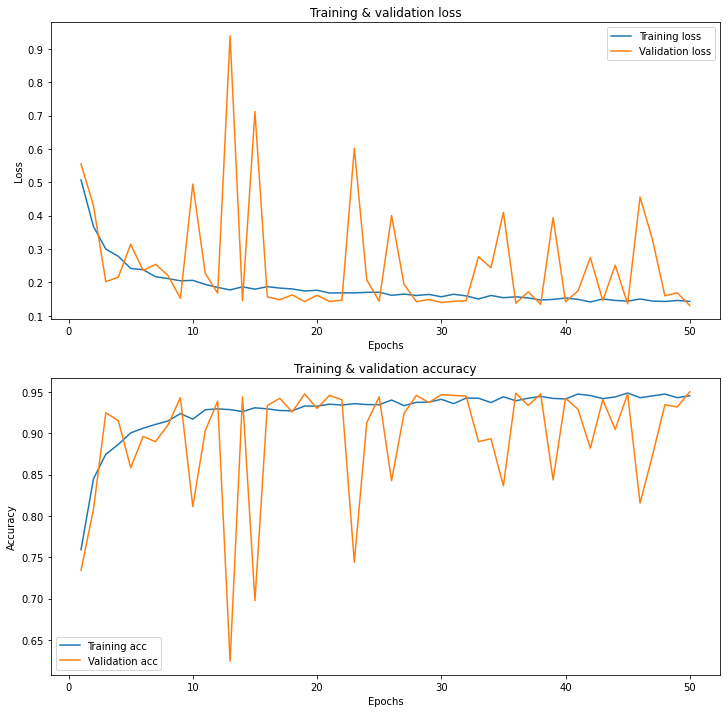

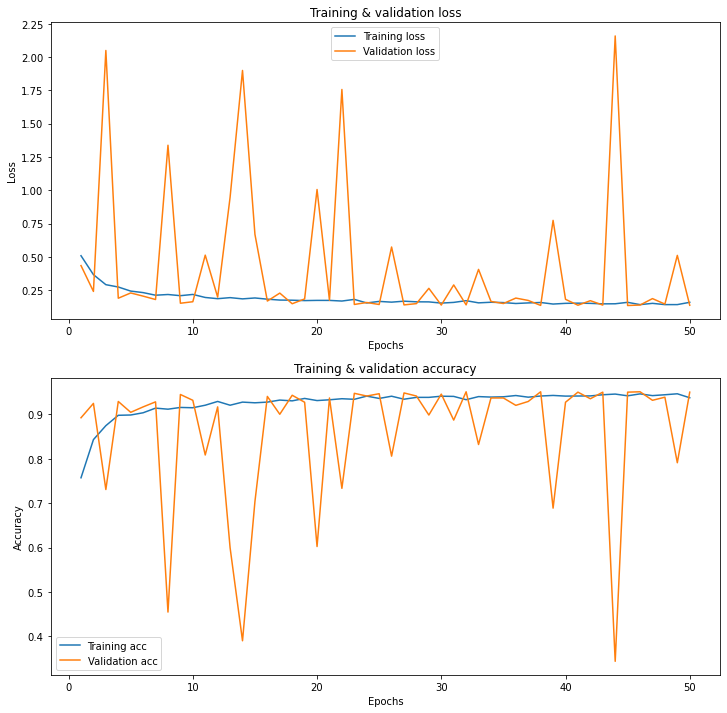

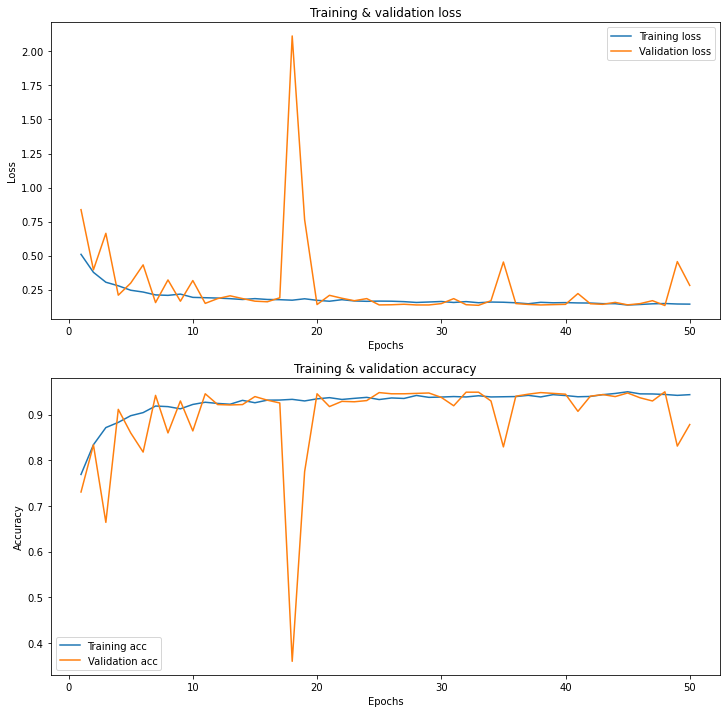

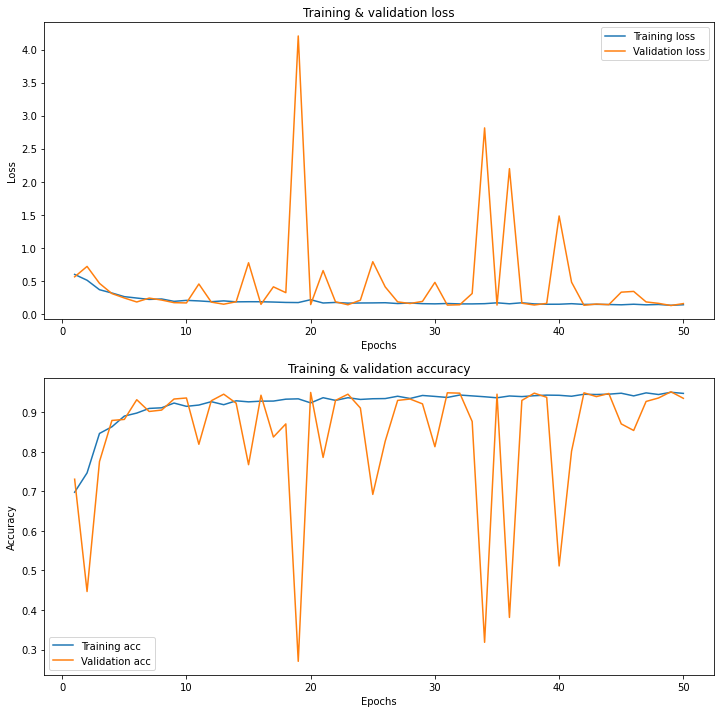

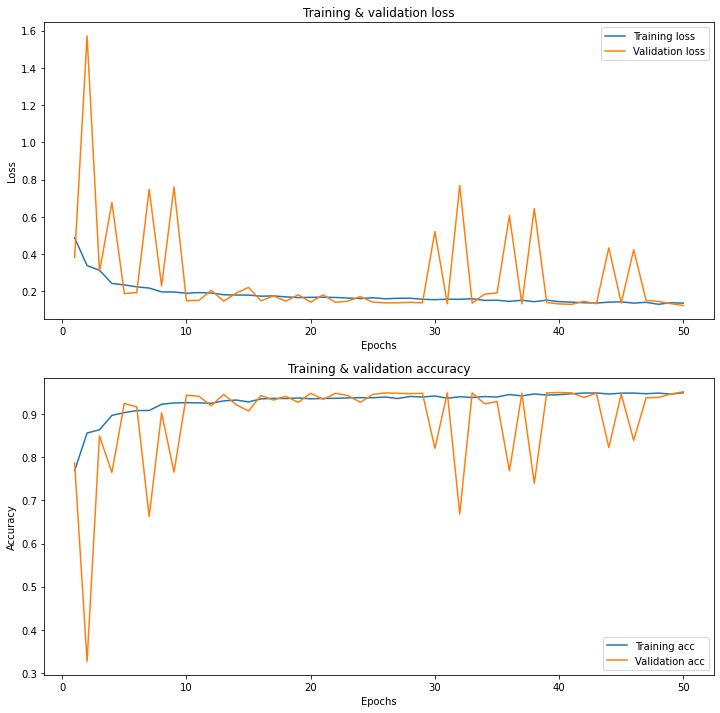

In [296]:
kf = KFold(5, shuffle=True, random_state=123)
fold=0
fold_results = []
for train, val in kf.split(X, Y):
    fold+=1
    print("Results for fold",fold)

    baseline_model = models.Sequential()
    baseline_model.add(layers.Dense(20, activation='relu', input_shape=(12288,)))
    baseline_model.add(layers.Dense(10, activation='relu'))
    baseline_model.add(layers.Dense(1, activation='sigmoid'))
    baseline_model.compile(optimizer="sgd",
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

    baseline_model_fit = baseline_model.fit(X_train,
                                            y_train,
                                            epochs=50,
                                            batch_size=32,
                                            validation_data=(X_test, y_test))
    model_results(baseline_model,baseline_model_fit)
    results = baseline_model.evaluate(X_val,y_val)
    fold_results.append(results)

In [297]:
fold_results

[[0.2507811658310168, 0.9015151515151515],
 [0.2537107359279286, 0.9015151515151515],
 [0.39247242745124933, 0.8560606060606061],
 [0.2931777437527974, 0.8863636363636364],
 [0.24259637973525308, 0.9090909090909091]]

As we can see above, our baseline model seems to be performing great in terms of accuracy and loss, however, it appears we are overfitting. According to Francois Chollet, there are 4 ways we can reduce overfitting:

* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout

As we are currently using all of the training data, and the capacity of our baseline model is already pretty low, we will proceed by first adding regularization.

### Model 1 - Add Hidden Layers, Regularization, and Dropout:

In [72]:
model_1 = models.Sequential()
model_1.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(12288,)))
model_1.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [73]:
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_1_fit = model_1.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Train on 4338 samples, validate on 894 samples
Epoch 1/50
4338/4338 [==============================] - 2s 369us/step - loss: 0.8500 - acc: 0.7725 - val_loss: 1.1674 - val_acc: 0.5000
Epoch 2/50
4338/4338 [==============================] - 1s 276us/step - loss: 0.7336 - acc: 0.8066 - val_loss: 0.8382 - val_acc: 0.5347
Epoch 3/50
4338/4338 [==============================] - 1s 284us/step - loss: 0.6515 - acc: 0.8419 - val_loss: 0.8727 - val_acc: 0.7651
Epoch 4/50
4338/4338 [==============================] - 1s 290us/step - loss: 0.6311 - acc: 0.8536 - val_loss: 0.8694 - val_acc: 0.7953
Epoch 5/50
4338/4338 [==============================] - 1s 286us/step - loss: 0.5850 - acc: 0.8873 - val_loss: 0.7186 - val_acc: 0.8859
Epoch 6/50
4338/4338 [==============================] - 1s 284us/step - loss: 0.5824 - acc: 0.8912 - val_loss: 0.5964 - val_acc: 0.9239
Epoch 7/50
4338/4338 [==============================] - 1s 285us/step - loss: 0.5695 - acc: 0.9055 - val_loss: 0.7987 - val_acc: 0.8535
E

In [74]:
def compare_model_results(baseline_model, baseline_model_fit, model, model_fit):
    
    model_baseline = baseline_model
    model_baseline_fit = baseline_model_fit
    model_func = model
    model_fit_func = model_fit
    results_train_baseline = model_baseline.evaluate(X_train, y_train)
    results_test_baseline = model_baseline.evaluate(X_test, y_test)
    results_val_baseline = model_baseline.evaluate(X_val, y_val)
    results_train_model = model_func.evaluate(X_train, y_train)
    results_test_model = model_func.evaluate(X_test, y_test)
    results_val_model = model_func.evaluate(X_val, y_val)
    
    baseline_model_val_dict = model_baseline_fit.history
    baseline_model_val_dict.keys()
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    model_loss_values = model_val_dict['loss']
    model_val_loss_values = model_val_dict['val_loss']
    model_acc_values = model_val_dict['acc'] 
    model_val_acc_values = model_val_dict['val_acc']
    model_epochs = range(1, len(model_loss_values) + 1)
    
    baseline_loss_values = baseline_model_val_dict['loss']
    baseline_val_loss_values = baseline_model_val_dict['val_loss']
    baseline_acc_values = baseline_model_val_dict['acc'] 
    baseline_val_acc_values = baseline_model_val_dict['val_acc']
    baseline_epochs = range(1, len(baseline_loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
    
    ax.plot(model_epochs, model_loss_values, label='Training loss (Model)')
    ax.plot(model_epochs, model_val_loss_values, label='Validation loss (Model)')
    ax.plot(baseline_epochs, baseline_loss_values, label='Training loss (Baseline)')
    ax.plot(baseline_epochs, baseline_val_loss_values, label='Validation loss (Baseline)')
    ax.set_title('Training & Validation Loss Current Model vs Baseline')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(model_epochs, model_acc_values, label='Training acc (Model)')
    ax2.plot(model_epochs, model_val_acc_values, label='Validation acc (Model)')
    ax2.plot(baseline_epochs, baseline_acc_values, label='Training acc (Baseline)')
    ax2.plot(baseline_epochs, baseline_val_acc_values, label='Validation acc (Baseline)')
    ax2.set_title('Training & Validation Accuracy Current Model vs Baseline')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    
    return print("\nBaseline Model Train Results (Loss, Acc.):", results_train_baseline), print("Baseline Model Test Results (Loss, Acc.):", results_test_baseline), print("Baseline Model Val Results (Loss, Acc.):", results_val_baseline), print("\nCurrent Model Train Results (Loss, Acc.):", results_train_model), print("Current Model Test Results (Loss, Acc.):", results_test_model, print("Current Model Val Results (Loss, Acc.):", results_val_model))

894/894 [==============================] - 0s 128us/step

Baseline Model Train Results (Loss, Acc.): [0.104984645188583, 0.9644997694790226]
Baseline Model Test Results (Loss, Acc.): [0.75232406380849, 0.7836538461538461]
Baseline Model Val Results (Loss, Acc.): [0.17438668159297116, 0.9574944062254306]

Current Model Train Results (Loss, Acc.): [0.411161830234, 0.9442139233571145]
Current Model Val Results (Loss, Acc.): [0.7957884923990407, 0.8467561513252173]
Current Model Test Results (Loss, Acc.): [2.494797089161017, 0.6842948717948718] None


(None, None, None, None, None)

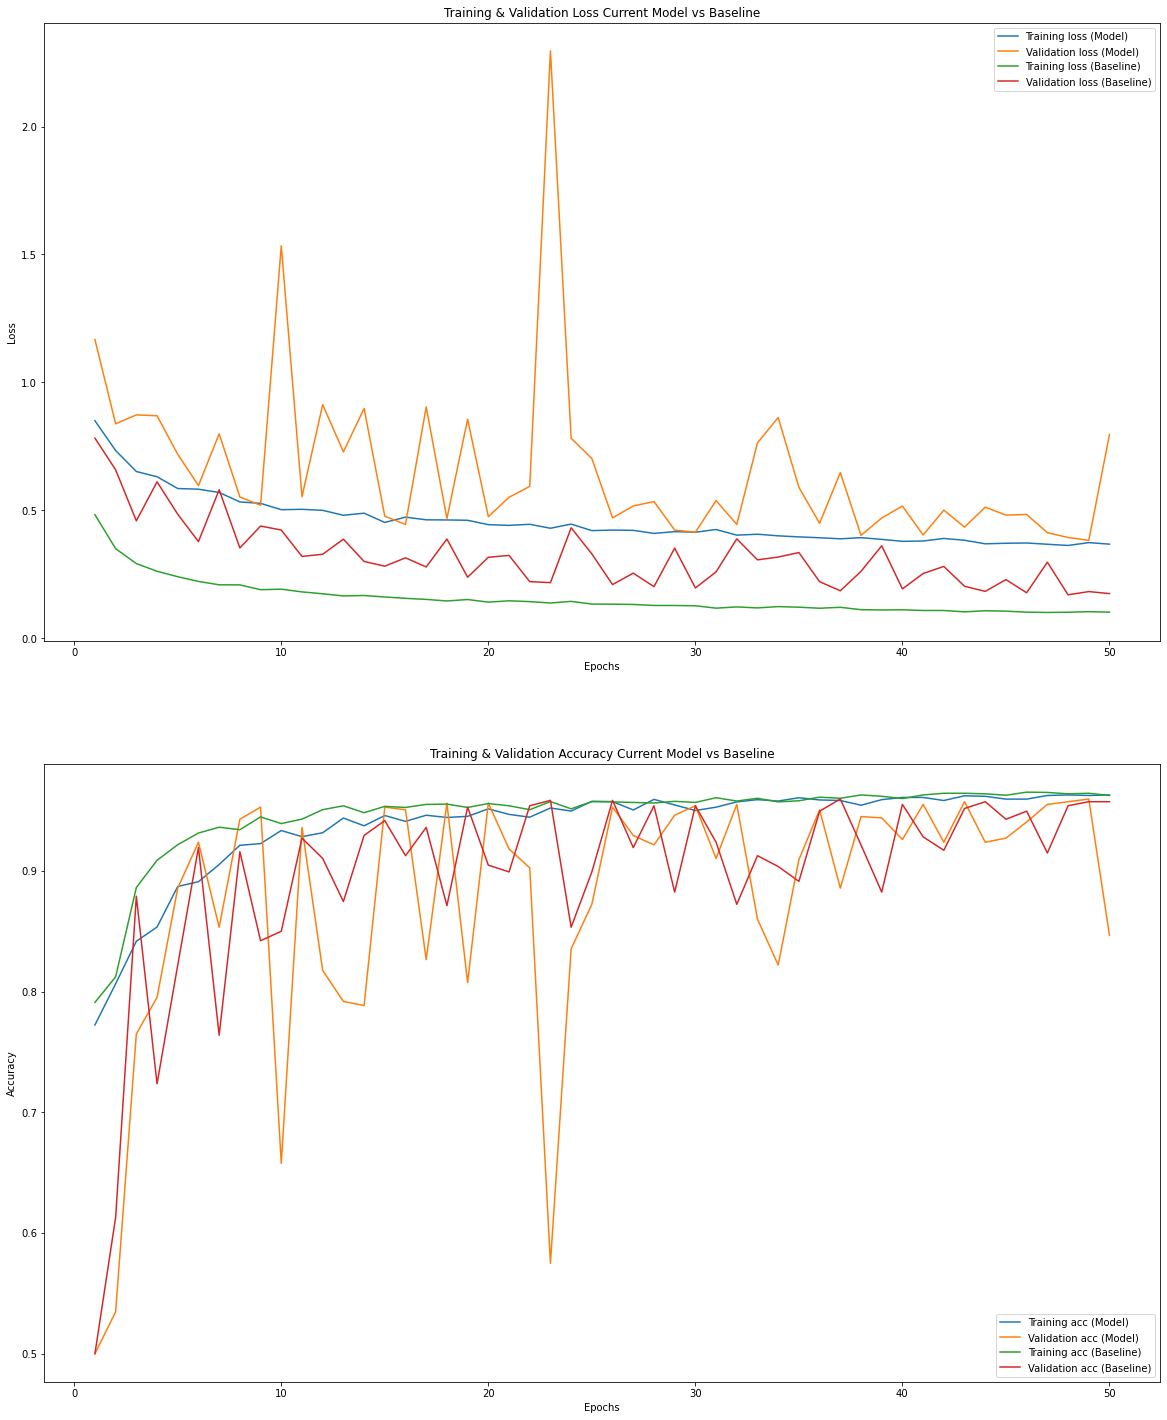

In [75]:
compare_model_results(baseline_model, baseline_model_fit, model_1, model_1_fit)

As we can see above, our model appears to be performing better than our baseline model. We sacrifice some of our accuracy for better testing results, and we no longer appear to be overfitting. Let's try creating a CNN model to see if we can develop a better test accuracy.

### Model 2: CNN Model

In [76]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(12288,)))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [77]:
start = datetime.datetime.now()
start

datetime.datetime(2022, 2, 18, 14, 30, 17, 243112)

In [78]:
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2_fit = model_2.fit(train_images,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, y_val))

Train on 4338 samples, validate on 894 samples
Epoch 1/50
4338/4338 [==============================] - 12s 3ms/step - loss: 0.7794 - acc: 0.7875 - val_loss: 1.0481 - val_acc: 0.5000
Epoch 2/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.7537 - acc: 0.7916 - val_loss: 1.0209 - val_acc: 0.5000
Epoch 3/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.7287 - acc: 0.7921 - val_loss: 1.0503 - val_acc: 0.5000
Epoch 4/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.6793 - acc: 0.7911 - val_loss: 0.8824 - val_acc: 0.5000
Epoch 5/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.6337 - acc: 0.7981 - val_loss: 0.9097 - val_acc: 0.5000
Epoch 6/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.6145 - acc: 0.8047 - val_loss: 0.7587 - val_acc: 0.5503
Epoch 7/50
4338/4338 [==============================] - 11s 3ms/step - loss: 0.5710 - acc: 0.8227 - val_loss: 0.6777 - val_acc: 0.8054
Epoch 8/

In [79]:
end = datetime.datetime.now()
elapsed = end - start
print('Training with data augmentation took a total of {}'.format(elapsed))

Training with data augmentation took a total of 0:10:37.976263


In [80]:
def compare_model_results_CNN(baseline_model, baseline_model_fit, model, model_fit):
    
    model_baseline = baseline_model
    model_baseline_fit = baseline_model_fit
    model_func = model
    model_fit_func = model_fit
    results_train_baseline = model_baseline.evaluate(X_train, y_train)
    results_test_baseline = model_baseline.evaluate(X_test, y_test)
    results_val_baseline = model_baseline.evaluate(X_val, y_val)
    results_train_model = model_func.evaluate(train_images, y_train)
    results_test_model = model_func.evaluate(test_images, y_test)
    results_val_model = model_func.evaluate(val_images, y_val)
    
    baseline_model_val_dict = model_baseline_fit.history
    baseline_model_val_dict.keys()
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    model_loss_values = model_val_dict['loss']
    model_val_loss_values = model_val_dict['val_loss']
    model_acc_values = model_val_dict['acc'] 
    model_val_acc_values = model_val_dict['val_acc']
    model_epochs = range(1, len(model_loss_values) + 1)
    
    baseline_loss_values = baseline_model_val_dict['loss']
    baseline_val_loss_values = baseline_model_val_dict['val_loss']
    baseline_acc_values = baseline_model_val_dict['acc'] 
    baseline_val_acc_values = baseline_model_val_dict['val_acc']
    baseline_epochs = range(1, len(baseline_loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
    
    ax.plot(model_epochs, model_loss_values, label='Training loss (Model)')
    ax.plot(model_epochs, model_val_loss_values, label='Validation loss (Model)')
    ax.plot(baseline_epochs, baseline_loss_values, label='Training loss (Baseline)')
    ax.plot(baseline_epochs, baseline_val_loss_values, label='Validation loss (Baseline)')
    ax.set_title('Training & Validation Loss Current Model vs Baseline')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(model_epochs, model_acc_values, label='Training acc (Model)')
    ax2.plot(model_epochs, model_val_acc_values, label='Validation acc (Model)')
    ax2.plot(baseline_epochs, baseline_acc_values, label='Training acc (Baseline)')
    ax2.plot(baseline_epochs, baseline_val_acc_values, label='Validation acc (Baseline)')
    ax2.set_title('Training & Validation Accuracy Current Model vs Baseline')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    
    return print("\nBaseline Model Train Results (Loss, Acc.):", results_train_baseline), print("Baseline Model Test Results (Loss, Acc.):", results_test_baseline), print("Baseline Model Val Results (Loss, Acc.):", results_val_baseline), print("\nCurrent Model Train Results (Loss, Acc.):", results_train_model), print("Current Model Test Results (Loss, Acc.):", results_test_model, print("Current Model Val Results (Loss, Acc.):", results_val_model))

894/894 [==============================] - 1s 710us/step

Baseline Model Train Results (Loss, Acc.): [0.104984645188583, 0.9644997694790226]
Baseline Model Test Results (Loss, Acc.): [0.75232406380849, 0.7836538461538461]
Baseline Model Val Results (Loss, Acc.): [0.17438668159297116, 0.9574944062254306]

Current Model Train Results (Loss, Acc.): [0.22867544015303576, 0.9824804057169202]
Current Model Val Results (Loss, Acc.): [0.3499481484660633, 0.9463087238988087]
Current Model Test Results (Loss, Acc.): [1.7230633008174407, 0.7355769230769231] None


(None, None, None, None, None)

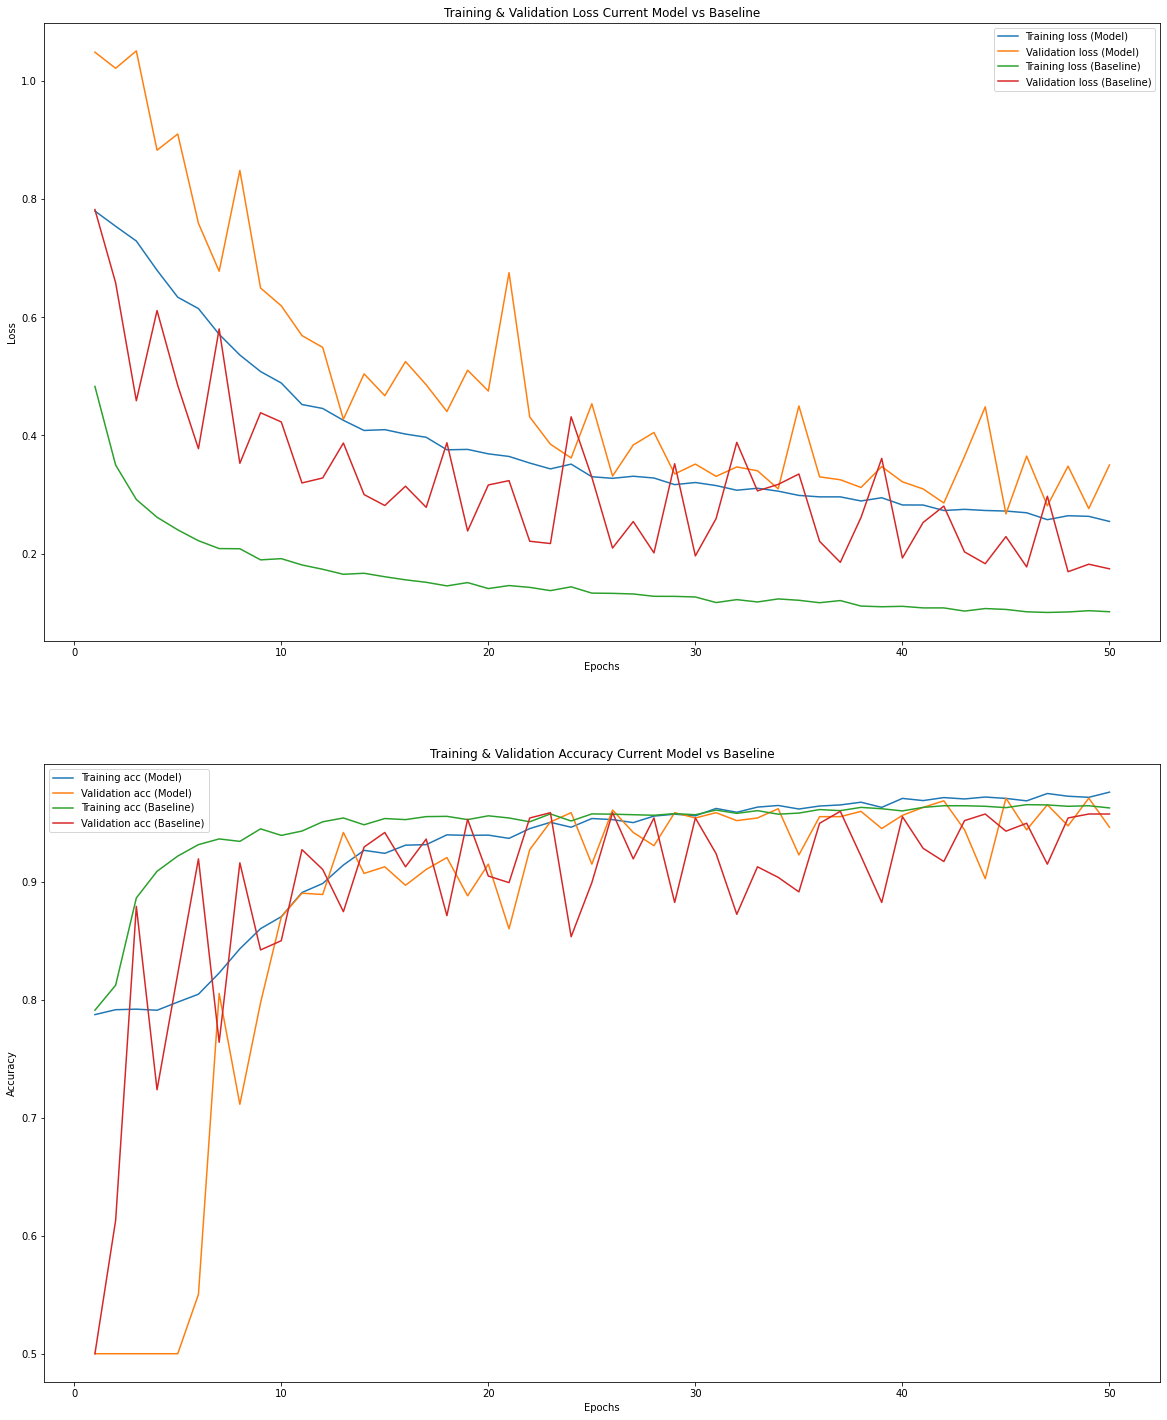

In [81]:
compare_model_results_CNN(baseline_model, baseline_model_fit, model_2, model_2_fit)